## Models with a single (or a few) halos with user-specified properties 

While the main purpose and utility of pyHalo is to permit rapid and intuitive generation of large populations of dark matter halos, you can also make use of pyHalo to generate single-halo models, and easily compute their lensing properties for use with lenstronomy. 

In [1]:
from pyHalo.single_realization import SingleHalo
from pyHalo.Halos.lens_cosmo import LensCosmo
from pyHalo.concentration_models import preset_concentration_models
import numpy as np
import matplotlib.pyplot as plt

### Models with a single halo

In [24]:
halo_mass = 10 ** 8
x_arcsec = 0.
y_arcsec = 0.0
z_halo = 0.5

zsource = 1.5 
# the source redshift is needed to specify the center of the rendering volume, something necessary for full
# halo populations. The source redshift won't actually matter for single-halo models. However, if you want to do
# multi-plane lensing computations with lenstronomy, you will need the source redshift
zlens = 0.5 # possibly irrelevant for single-halo models, depending on whether the object is a subhalo
mass_definition = 'NFW'
subhalo_flag = False
lens_cosmo = LensCosmo(zlens, zsource)
astropy_class = lens_cosmo.cosmo

model, kwargs_concentration_model = preset_concentration_models('DIEMERJOYCE19')
kwargs_concentration_model['scatter'] = False
kwargs_concentration_model['cosmo'] = astropy_class
concentration_model = model(**kwargs_concentration_model)

halo_truncation_model = None # an NFW halo has no formal truncation radius, so we don't need to specify this 

In [28]:
kwargs_halo_model = {'truncation_model': halo_truncation_model, 
                     'concentration_model': concentration_model,
                    'kwargs_density_profile': {}}
single_halo = SingleHalo(halo_mass, x_arcsec, y_arcsec, mass_definition, z_halo, zlens, zsource,
                        subhalo_flag, kwargs_halo_model=kwargs_halo_model)
lens_model_list, redshift_array, kwargs_lens, _ = single_halo.lensing_quantities()

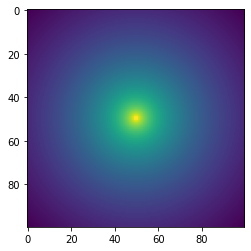

In [29]:
from lenstronomy.LensModel.lens_model import LensModel

lens_model = LensModel(lens_model_list)

_r = np.linspace(-0.5, 0.5, 100)
xx, yy = np.meshgrid(_r, _r)
shape0 = xx.shape
kappa = lens_model.kappa(xx.ravel(), yy.ravel(), kwargs_lens).reshape(shape0)

plt.imshow(np.log10(kappa))

### Models with multiple halos at different redshifts

You can make a realization with several single halos in the following way

In [4]:
halo_masses = [10 ** 10, 10**8.4, 10**9]
x_arcsec = [0., 0.25, -0.1]
y_arcsec = [0.0, -0.3, 0.4]
z_halo = [0.3, 0.5, 0.7]

zsource = 1.5 
z_main_deflector = None
realization = None
for (mass, x, y, z) in zip(halo_masses, x_arcsec, y_arcsec, z_halo):
    
    if realization is None:
        realization = SingleHalo(mass, x, y, mass_definition, z, zlens, zsource,
                        subhalo_flag, kwargs_halo_model=kwargs_halo_model)
    
    else:
        # use the join method to combine two realizations (or single halos)
        single_halo = SingleHalo(mass, x, y, mass_definition, z, zlens, zsource,
                        subhalo_flag, kwargs_halo_model=kwargs_halo_model)
        realization = realization.join(single_halo)

lens_model_list, redshift_array, kwargs_lens, _ = realization.lensing_quantities()

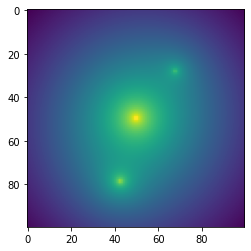

In [5]:
from lenstronomy.LensModel.lens_model import LensModel

lens_model = LensModel(lens_model_list, lens_redshift_list=list(redshift_array), multi_plane=True, z_source=zsource)

_r = np.linspace(-0.7, 0.7, 100)
xx, yy = np.meshgrid(_r, _r)
shape0 = xx.shape
kappa_multiplane = lens_model.kappa(xx.ravel(), yy.ravel(), kwargs_lens).reshape(shape0)

plt.imshow(np.log10(kappa_multiplane))

You can see some non-linear effects of multi-plane lensing manifest below, effectively changing the (perceived) angular coordinate of structures behind the first deflector

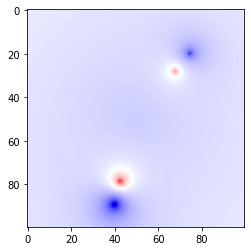

In [6]:
lens_model_single_plane = LensModel(lens_model_list)

_r = np.linspace(-0.5, 0.5, 100)
xx, yy = np.meshgrid(_r, _r)
shape0 = xx.shape
kappa_single_plane = lens_model_single_plane.kappa(xx.ravel(), yy.ravel(), kwargs_lens).reshape(shape0)

plt.imshow(kappa_multiplane - kappa_single_plane, vmin=-0.05, vmax=0.05, cmap='bwr')